In [242]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-dataset/Titanic-Dataset.csv


In [243]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [284]:
#Carregando Dados
data = pd.read_csv('/kaggle/input/titanic-dataset/Titanic-Dataset.csv')

In [245]:
# Extraindo títulos
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Visualizar os títulos únicos
print(data['Title'].value_counts())

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64


In [246]:
# Agrupando títulos raros para entender se possuem correlação direta com a sobrevivência
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
data['Title'] = data['Title'].replace(rare_titles, 'Other')
data['Title'] = data['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# Transformar em numérico (One-Hot ou Label Encoding)
data = pd.get_dummies(data, columns=['Title'], drop_first=True)
data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

In [247]:
#Dropando colunas que intuitivamente não possuem correlação relevante com nossa variável target
data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

In [248]:
data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,False,True,False,False,True,False,True
1,2,1,1,38.0,1,0,71.2833,False,False,True,False,False,False,False
2,3,1,3,26.0,0,0,7.9250,True,False,False,False,False,False,True
3,4,1,1,35.0,1,0,53.1000,False,False,True,False,False,False,True
4,5,0,3,35.0,0,0,8.0500,False,True,False,False,True,False,True


In [249]:
# Calcular a correlação com Survived
correlations = data.corr()['Survived'].sort_values(ascending=False)

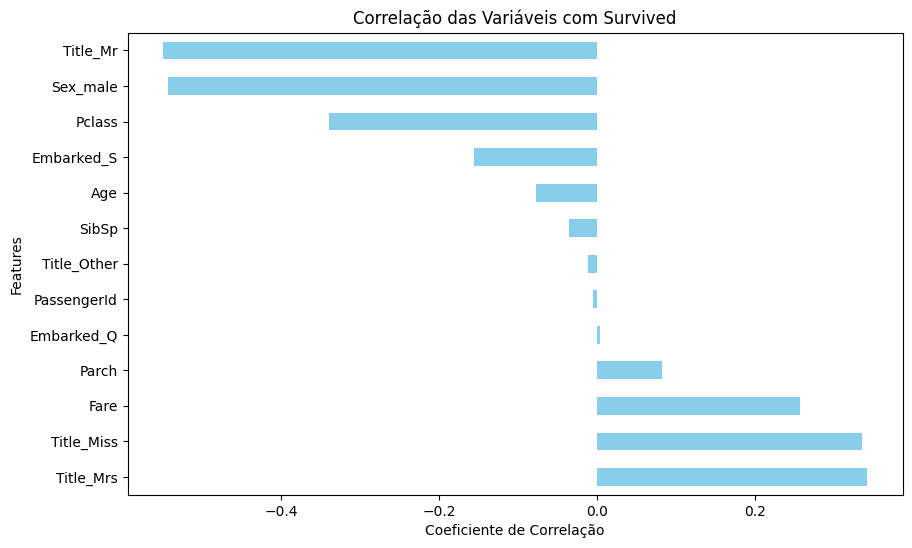

In [250]:
correlations.drop('Survived').plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Correlação das Variáveis com Survived')
plt.xlabel('Coeficiente de Correlação')
plt.ylabel('Features')
plt.show()

In [251]:
# Calcular a correlação absoluta com Age
correlations = data.corr()['Age'].abs().sort_values(ascending=False)
print("Correlação Absoluta com Age:\n", correlations)

# Selecionar variáveis com alta correlação absoluta (exemplo: acima de 0.3)
high_corr_features = correlations[correlations > 0.3].index.tolist()
print("Variáveis com alta correlação (positiva ou negativa) com Age:", high_corr_features)


Correlação Absoluta com Age:
 Age            1.000000
Pclass         0.369226
SibSp          0.308247
Title_Miss     0.277827
Title_Mr       0.206341
Title_Other    0.194639
Parch          0.189119
Title_Mrs      0.178069
Fare           0.096067
Sex_male       0.093254
Survived       0.077221
PassengerId    0.036847
Embarked_S     0.032523
Embarked_Q     0.022405
Name: Age, dtype: float64
Variáveis com alta correlação (positiva ou negativa) com Age: ['Age', 'Pclass', 'SibSp']


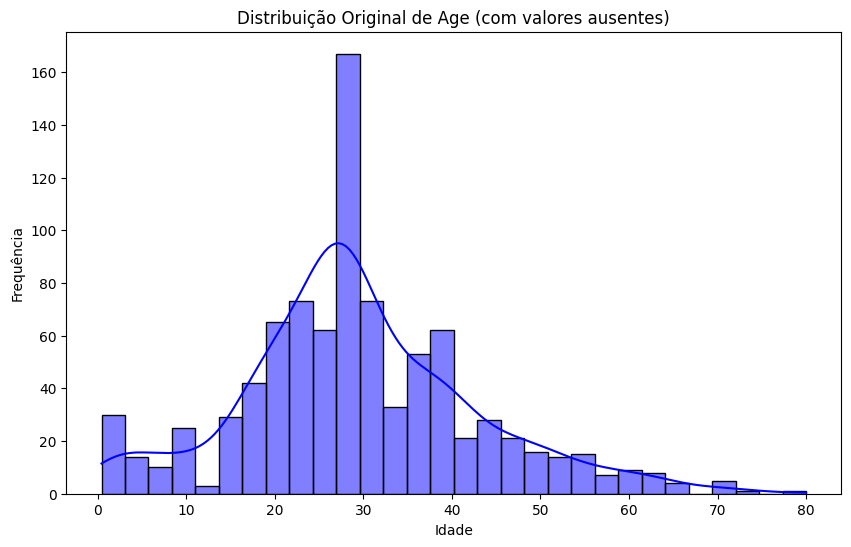

In [252]:
# Visualizar a distribuição original dos dados de Age para selecionar nossa imputação de dados
plt.figure(figsize=(10, 6))
sns.histplot(X['Age'], kde=True, bins=30, color='blue')
plt.title("Distribuição Original de Age (com valores ausentes)")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()

In [253]:
# Excluir a própria coluna 'Age' da lista de features para imputação de dados utilizando RANDOM FOREST
features_for_imputation = [col for col in high_corr_features if col != 'Age']
data_rf = data.copy()
# Dados onde Age não está faltando
age_not_missing = data_rf[data_rf['Age'].notnull()]
# Dados onde Age está faltando
age_missing = data_rf[data_rf['Age'].isnull()]
# Criar conjuntos para treino e imputação
X_train = age_not_missing[features_for_imputation]
y_train = age_not_missing['Age']
X_pred = age_missing[features_for_imputation]


In [254]:
from sklearn.ensemble import RandomForestRegressor
# Treinando o modelo com dados não faltantes
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Prevendo os valores ausentes de Age
predicted_ages = rf_model.predict(X_pred)

# Substituindo os valores ausentes no DataFrame original
data_rf.loc[data_rf['Age'].isnull(), 'Age'] = predicted_ages



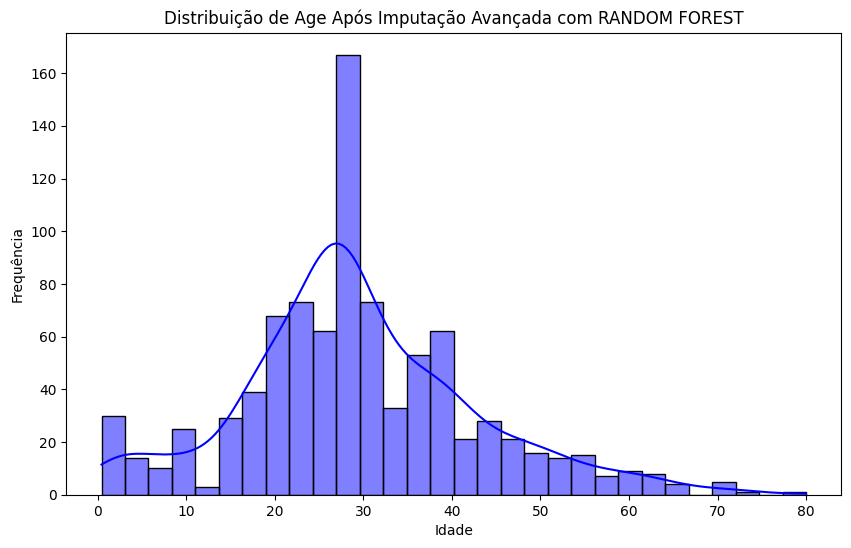

In [255]:
#Vamos verificar a distribuição original de age e a nova
# Visualizar a distribuição de Age após a imputação
plt.figure(figsize=(10, 6))
sns.histplot(data_rf['Age'], kde=True, bins=30, color='blue')
plt.title("Distribuição de Age Após Imputação Avançada com RANDOM FOREST")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()

In [256]:
# Excluir a própria coluna 'Age' da lista de features para imputação de dados utilizando GRADIENT BOOST
features_for_imputation = [col for col in high_corr_features if col != 'Age']
data_gb = data.copy()
# Dados onde Age não está faltando
age_not_missing = data_gb[data_gb['Age'].notnull()]
# Dados onde Age está faltando
age_missing = data_gb[data_gb['Age'].isnull()]
# Criar conjuntos para treino e imputação
X_train = age_not_missing[features_for_imputation]
y_train = age_not_missing['Age']
X_pred = age_missing[features_for_imputation]

In [257]:
from sklearn.ensemble import GradientBoostingRegressor

# Treinar o modelo
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Prever e substituir valores ausentes
predicted_ages = gb_model.predict(X_pred)
data_gb.loc[data_gb['Age'].isnull(), 'Age'] = predicted_ages


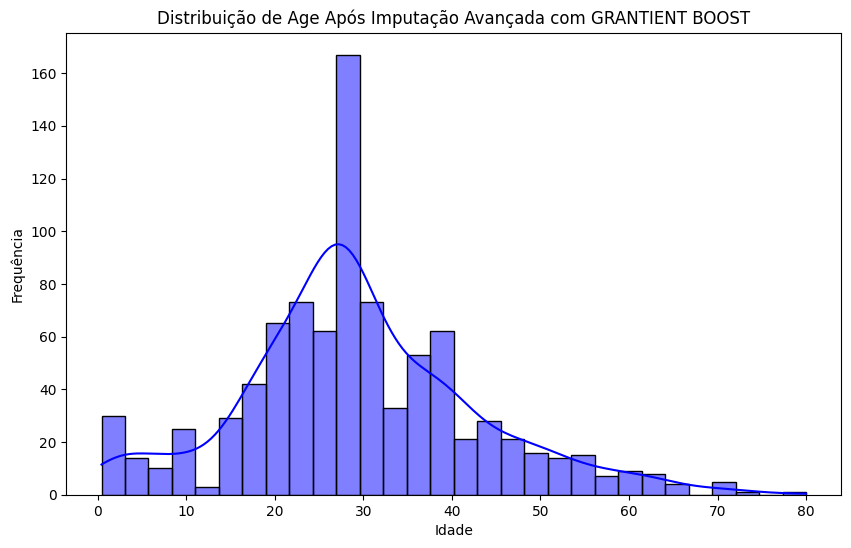

In [258]:
#Vamos verificar a distribuição original de age e a nova
# Visualizar a distribuição de Age após a imputação
plt.figure(figsize=(10, 6))
sns.histplot(data_gb['Age'], kde=True, bins=30, color='blue')
plt.title("Distribuição de Age Após Imputação Avançada com GRANTIENT BOOST")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()

In [259]:
age_not_null = data['Age'].dropna()
print(age_not_null.describe())

print("\nEstatísticas Após Imputação com RANDOM FOREST:")
print(data_rf['Age'].describe())

print("\nEstatísticas Após Imputação com GRADIENT BOOST:")
print(data_gb['Age'].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Estatísticas Após Imputação com RANDOM FOREST:
count    891.000000
mean      29.388922
std       13.343268
min        0.420000
25%       22.000000
50%       27.417551
75%       37.000000
max       80.000000
Name: Age, dtype: float64

Estatísticas Após Imputação com GRADIENT BOOST:
count    891.000000
mean      29.407172
std       13.347598
min        0.420000
25%       22.000000
50%       27.630328
75%       37.000000
max       80.000000
Name: Age, dtype: float64


In [260]:
#Como utilizei os modelos apenas para teste seguirei o método do gradient boost que apresentou uma distribuição mais parecida
# (importante observar que não alteramos os hiperparâmetros para prever age, então não necessariamente o método GB será sempre melhor)
data.loc[data['Age'].isnull(), 'Age'] = predicted_ages

        Feature  Importance
1           Age    0.239207
4          Fare    0.237636
9      Sex_male    0.140867
6      Title_Mr    0.117996
0        Pclass    0.085169
2         SibSp    0.052708
3         Parch    0.033116
5    Title_Miss    0.028811
7     Title_Mrs    0.026545
11   Embarked_S    0.018884
10   Embarked_Q    0.009581
8   Title_Other    0.009480


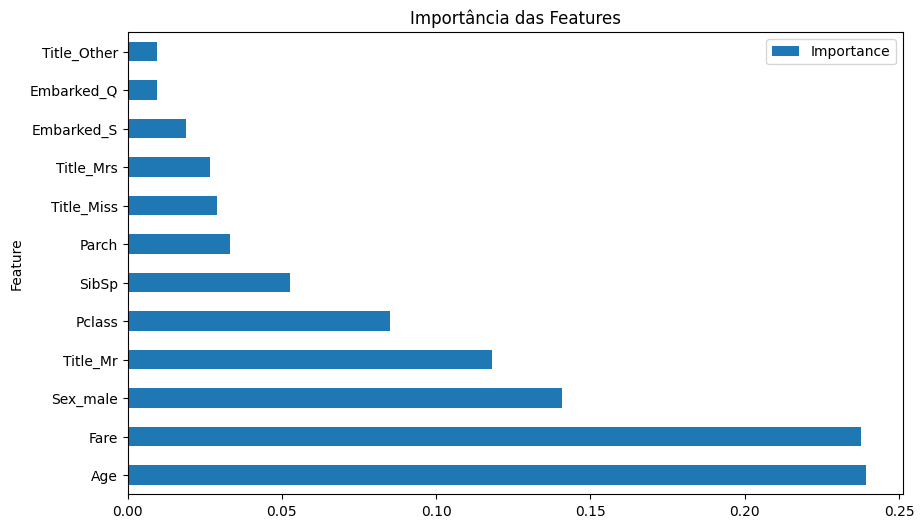

In [261]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Treinando um Random Forest para calcular a importância das features, importante remover features que não possuem correlação direta e irão
# Introduzir ruído ao modelo, como 'PassangerId'
rf = RandomForestClassifier(random_state=42)
rf.fit(data.drop(columns=['Survived', 'PassengerId']), data['Survived'])

# Criar um DataFrame com as importâncias
feature_importances = pd.DataFrame({
    'Feature': data.drop(columns=['Survived', 'PassengerId']).columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Exibir as features mais importantes
print(feature_importances)

# Visualizar as importâncias
import matplotlib.pyplot as plt
feature_importances.set_index('Feature').plot(kind='barh', figsize=(10, 6))
plt.title("Importância das Features")
plt.show()


In [262]:
from sklearn.model_selection import train_test_split

# Dividir os dados em treino (80%) e teste (20%)
X = data.drop(columns=['Survived', 'PassengerId'])  # Remover a variável target e identificadores
y = data['Survived']  # Target (variável de saída)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [263]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Treinar o modelo de Random Forest nos dados de treino
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Calcular a importância das features com base nos dados de treino
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Selecionar as features mais importantes (threshold > 0.05, por exemplo)
selected_features = feature_importances[feature_importances['Importance'] > 0.05]['Feature']
print("Features Selecionadas:", selected_features.tolist())


Features Selecionadas: ['Fare', 'Age', 'Sex_male', 'Title_Mr', 'Pclass', 'SibSp']


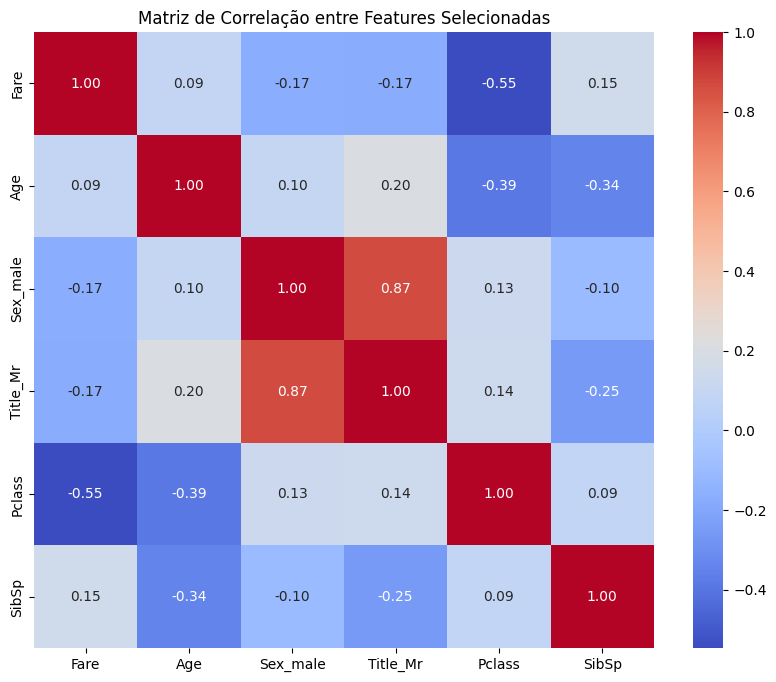

In [264]:
# Filtrar apenas as features selecionadas no dataset
correlation_matrix = X_train[selected_features].corr()

# Visualizar a matriz de correlação
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação entre Features Selecionadas")
plt.show()

In [265]:
selected_features

4        Fare
1         Age
9    Sex_male
6    Title_Mr
0      Pclass
2       SibSp
Name: Feature, dtype: object

In [266]:
# As features Title_Mr e Title_Miss possuem uma alta correlação com Sex_male, junto a isso sua correlação direta com a variável target não é tão
# Alta, por tanto vou optar por removê-las nessa experiência.
# Por enquanto vamos manter a feature de maior correlação com nosso target e remover 'Title_Mr'
# Lista de colunas para remover
columns_to_remove = ['Title_Mr', 'Title_Mrs']

# Remover as colunas de selected_features
selected_features = selected_features[~selected_features.isin(columns_to_remove)]

# Verificar as features restantes
print("Features Selecionadas Após Remoção:", selected_features.tolist())




Features Selecionadas Após Remoção: ['Fare', 'Age', 'Sex_male', 'Pclass', 'SibSp']


In [267]:
# Reduzir o conjunto de features para as selecionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Treinar o modelo novamente com as features selecionadas
rf.fit(X_train_selected, y_train)


RandomForestClassifier(random_state=42)

In [268]:
#Vamos agora avaliar nosso modelo no Conjunto de testes :D
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Fazer previsões no conjunto de teste
y_pred = rf.predict(X_test_selected)

# Gerar relatório de classificação
print("Relatório de Classificação no Conjunto de Teste:")
print(classification_report(y_test, y_pred))

# Calcular e exibir ROC-AUC
y_proba = rf.predict_proba(X_test_selected)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC no Conjunto de Teste: {roc_auc:.4f}")


Relatório de Classificação no Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

ROC-AUC no Conjunto de Teste: 0.8898


In [269]:
#Podemos interpretar aqui que nosso modelo performa melhor prevendo quem não sobreviveu, possuindo um valor de recall ligeiramente maior
#Mas aparentemente bem equilibrado, ainda podemos testar a consistência do mesmo

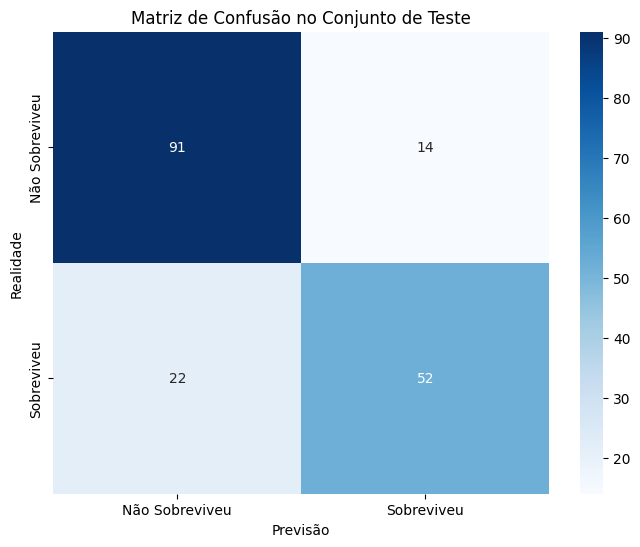

In [270]:
#Criando visualizações para facilitar nossa vida!
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobreviveu', 'Sobreviveu'], yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title('Matriz de Confusão no Conjunto de Teste')
plt.xlabel('Previsão')
plt.ylabel('Realidade')
plt.show()


In [271]:
# Por meio da validação cruzada podemos testar nosso modelo em diferentes subconjuntos do nosso dataset, assim
# Verificando a consistência dele em diferentes cenários (GENERALIZAÇÃO)
from sklearn.model_selection import cross_val_score

# Avaliar a performance com validação cruzada
cv_scores = cross_val_score(rf, X_train_selected, y_train, cv=5, scoring='accuracy')

print(f"Acurácia Média na Validação Cruzada: {cv_scores.mean():.4f}")
print(f"Desvio Padrão na Validação Cruzada: {cv_scores.std():.4f}")


Acurácia Média na Validação Cruzada: 0.8062
Desvio Padrão na Validação Cruzada: 0.0125


Com esses resultados podemos verificar que nosso modelo generaliza bem e possui uma baixa dispersão, mas será que podemos melhorá-lo?
Dado que temos poucos dados, podemos testar mais modelos, e principalmente, valores diferentes de hiperparâmetros!

## 1. Configurar os Modelos e Hiperparâmetros ##  
Primeiro, definimos os modelos e os hiperparâmetros que desejamos testar.

In [272]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

# Configuração de modelos e hiperparâmetros
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200, 500],
            'max_depth': [3, 5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42, solver='saga'),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l2', 'elasticnet'],
            'l1_ratio': [0.2, 0.5, 0.8]  # Elasticnet precisa disso
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}  # Sem hiperparâmetros importantes
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10]
        }
    }
}


## 2. Treinar e Avaliar os Modelos ##
Usamos GridSearchCV para otimizar os hiperparâmetros de cada modelo e comparamos os resultados usando validação cruzada, mas como
requer muito poder computacional e tempo, recorremos ao RandomSearchCV.

In [273]:
# Lista para armazenar resultados
results = []

for name, config in models.items():
    print(f"\nTreinando modelo: {name}")
    
    # Criar pipeline com padronização
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Padronizar dados
        ('model', config['model'])
    ])
    
    if name == 'Naive Bayes':
        # Apenas rodar o modelo sem RandomizedSearch
        pipeline.fit(X_train[selected_features], y_train)
        y_pred = pipeline.predict(X_test[selected_features])
        y_proba = pipeline.predict_proba(X_test[selected_features])[:, 1]
        
        # Calcular métricas
        accuracy = pipeline.score(X_test[selected_features], y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # Armazenar resultados
        results.append({
            'Model': name,
            'Best Params': 'N/A',
            'Trained Model': best_model, #Modelo ajustado para visualizar resultados finais
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        })
        
    else:
        # Configurar RandomizedSearchCV para os demais modelos
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions={'model__' + key: value for key, value in config['params'].items()},
            n_iter=100,  # Limitar a 100 combinações
            cv=5,  # Validação cruzada com 5 folds
            scoring='accuracy',
            verbose=0,
            random_state=42,
            n_jobs=-1
        )
        
        # Ajustar o modelo
        random_search.fit(X_train[selected_features], y_train)
        
        # Melhor modelo e hiperparâmetros
        best_model = random_search.best_estimator_
        print(f"Melhores hiperparâmetros para {name}: {random_search.best_params_}")
        
        # Avaliar no conjunto de teste
        y_pred = best_model.predict(X_test[selected_features])
        y_proba = best_model.predict_proba(X_test[selected_features])[:, 1]
        
        # Calcular métricas
        accuracy = random_search.best_score_
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # Armazenar os resultados
        results.append({
            'Model': name,
            'Best Params': random_search.best_params_,
            'Trained Model': best_model, #Modelo ajustado para visualizar resultados finais
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        })
        
        # Exibir relatório detalhado
        print(f"\nRelatório de Classificação para {name}:")
        print(classification_report(y_test, y_pred))


Treinando modelo: Random Forest
Melhores hiperparâmetros para Random Forest: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': 5, 'model__bootstrap': True}

Relatório de Classificação para Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.82      0.66      0.73        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.79       179


Treinando modelo: Logistic Regression


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/co

Melhores hiperparâmetros para Logistic Regression: {'model__penalty': 'elasticnet', 'model__l1_ratio': 0.2, 'model__C': 0.1}

Relatório de Classificação para Logistic Regression:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       105
           1       0.76      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179


Treinando modelo: Naive Bayes

Treinando modelo: Gradient Boosting
Melhores hiperparâmetros para Gradient Boosting: {'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.01}

Relatório de Classificação para Gradient Boosting:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81  


Resumo dos Resultados:
                 Model                                        Best Params  \
0        Random Forest  {'model__n_estimators': 200, 'model__min_sampl...   
1  Logistic Regression  {'model__penalty': 'elasticnet', 'model__l1_ra...   
2          Naive Bayes                                                N/A   
3    Gradient Boosting  {'model__n_estimators': 200, 'model__max_depth...   

                                       Trained Model  Accuracy  Precision  \
0  (StandardScaler(), (DecisionTreeClassifier(max...  0.837033   0.816667   
1  (StandardScaler(), LogisticRegression(C=0.1, l...  0.799123   0.757143   
2  (StandardScaler(), LogisticRegression(C=0.1, l...  0.765363   0.716216   
3  (StandardScaler(), ([DecisionTreeRegressor(cri...  0.824397   0.822581   

     Recall  F1-Score   ROC-AUC  
0  0.662162  0.731343  0.902317  
1  0.716216  0.736111  0.879794  
2  0.716216  0.716216  0.853411  
3  0.689189  0.750000  0.872780  


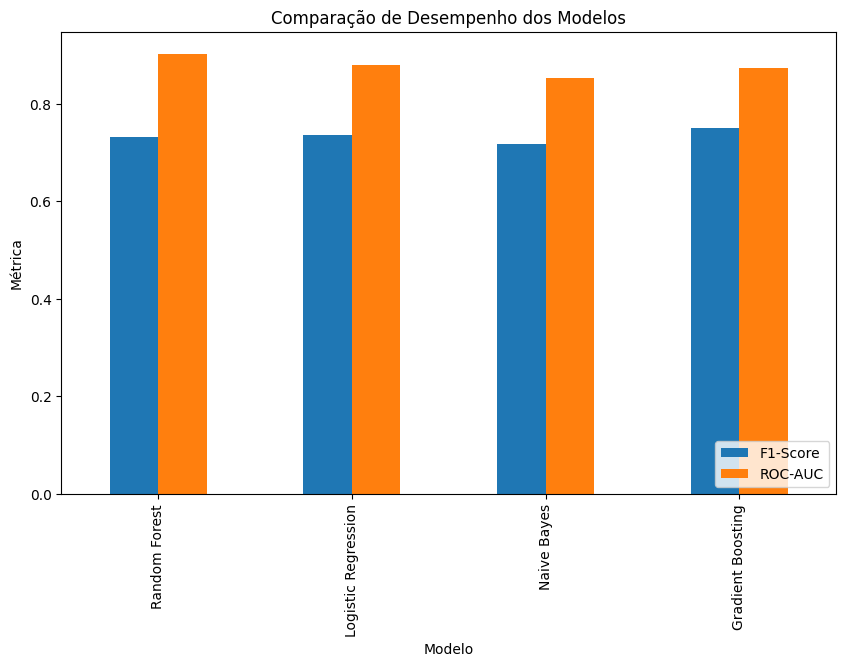

In [274]:
# Criar DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibir os resultados
print("\nResumo dos Resultados:")
print(results_df)

# Plotar comparação de F1-Score e ROC-AUC
results_df.set_index('Model')[['F1-Score', 'ROC-AUC']].plot(kind='bar', figsize=(10, 6))
plt.title("Comparação de Desempenho dos Modelos")
plt.ylabel("Métrica")
plt.xlabel("Modelo")
plt.legend(loc="lower right")
plt.show()


### Vou explicar esse pulo de complexidade agora! ###

Inicialmente selecionamos nossas variáveis e treinamos um modelo de RandomForest com hiperparâmetros padrões, já nessa etapa final fizemos o testes dos modelso de Árvores aleatórias, Regressão Logística, Naive Bayes e Gradient Boosting para hiperparâmetros aleatórios (100 para cada modelo) definidos em intervalos pré-definidos, por fim estamos vendo qual modelo performa melhor de forma balanceada 'F1-Score' e também seu desempenho geral na métrica ROC-AUC, o que mede um boma distinção entre as classes, mesmo em datasets desbalanceados

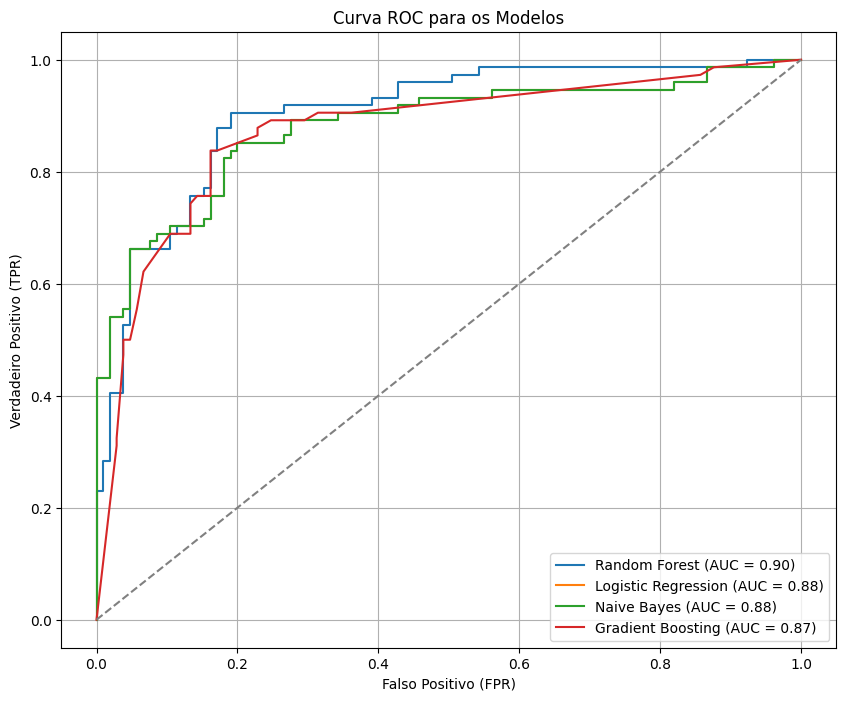

In [277]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Criar um dicionário para armazenar os resultados de cada modelo
roc_results = {}

# Iterar sobre os resultados armazenados
for result in results:
    name = result['Model']
    model = result['Trained Model']  # Obter o modelo treinado diretamente

    # Garantir que o modelo está ajustado (caso não esteja)
    if hasattr(model, 'fit'):  # Verificar se o modelo possui o método fit
        model.fit(X_train[selected_features], y_train)  # Ajustar nos dados de treino

    # Fazer previsões de probabilidade
    if hasattr(model, 'predict_proba'):  # Verificar se o modelo suporta predict_proba
        y_proba = model.predict_proba(X_test[selected_features])[:, 1]
    else:
        print(f"O modelo {name} não suporta predict_proba. Ignorando para ROC-AUC.")
        continue

    # Calcular a curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    # Armazenar os resultados
    roc_results[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

# Visualizar a curva ROC
plt.figure(figsize=(10, 8))

for model, data in roc_results.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{model} (AUC = {data["auc"]:.2f})')

# Linha de referência (aleatório)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customização do gráfico
plt.title('Curva ROC para os Modelos')
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Conclusão ##
### 1. Melhor Modelo (ROC-AUC Mais Alto): ###

Random Forest(AUC = 0.90): É o modelo mais confiável e eficaz para separar as classes neste problema.
### 2. Modelos Competitivos: ###

Logistic Regression e Naive Bayes (AUC = 0.88): Ambos têm desempenho semelhante e são boas alternativas.
### 3. Modelo Mais Fraco no Contexto: ###

Gradient Boosting (AUC = 0.87): Embora competitivo, é o que tem o menor AUC entre os quatro.
### 4. Curvas Mais Próximas do Canto Superior Esquerdo: ###

O modelo Random Forest maximiza o recall enquanto mantém baixos os falsos positivos, o que o torna o mais equilibrado.

In [279]:
# Agora pegamos o melhor modelo (random forest nesse caso), 
#"Perdemos em interpretabilidade em comparação com um naive bayes ou um árvore de decisão pura
# Mas no caso desse case o que importa é a previsão correta :D"
# Obter o modelo treinado correspondente
# Encontrar o nome do melhor modelo com base no ROC-AUC
best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
print(f"Melhor modelo baseado no ROC-AUC: {best_model_name}")

best_model = None
for result in results:
    if result['Model'] == best_model_name:
        best_model = result['Trained Model']  # Aqui recuperamos o modelo ajustado
        break

# Verificar se o modelo foi encontrado
if best_model is None:
    print("Erro: Não foi possível encontrar o modelo treinado.")
else:
    print("Modelo treinado recuperado com sucesso!")


Melhor modelo baseado no ROC-AUC: Random Forest
Modelo treinado recuperado com sucesso!
